In [1]:
#import data
import sklearn
import numpy as np
import pandas as pd
import os

print(sklearn.__version__)
data_path = "data_vectorized"


1.5.1


In [2]:
# index column | dimensions [1 to 100] | malicious (boolean y)
# 0            |
# 1            |
# 2            |

#grab csvs from data folder

def dataset_imp(file_path, data_path=data_path, shape_print=True):
    pd_dataframe = pd.read_csv(data_path + file_path)
    if shape_print:
        print(file_path, pd_dataframe.shape)
    return pd_dataframe

dataframes = {}

for file in os.listdir(data_path):
    if file.endswith(".csv"):
        base_name = os.path.splitext(file)[0]
        variable_name = f"df_{base_name.replace(' ', '_')}"
        
        dataframes[variable_name] = pd.read_csv(os.path.join(data_path, file))

print("Loaded DataFrames:", list(dataframes.keys()))

for name, df in dataframes.items():
    print(name, df.shape)
    print(df.duplicated().sum())

Loaded DataFrames: ['df_test_100', 'df_test_256', 'df_test_512', 'df_train_100', 'df_train_256', 'df_train_512', 'df_val_100', 'df_val_256', 'df_val_512']
df_test_100 (23265, 102)
0
df_test_256 (23265, 258)
0
df_test_512 (23265, 514)
0
df_train_100 (49855, 102)
0
df_train_256 (49855, 258)
0
df_train_512 (49855, 514)
0
df_val_100 (9972, 102)
0
df_val_256 (9972, 258)
0
df_val_512 (9972, 514)
0


In [ ]:

import lightgbm as lgb
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import random

c:\Users\jason\anaconda3\envs\datascience\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def df_xy(df, target="malicious"):
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame.")
    
    print(df.head())

    X = df.drop(columns=["Unnamed: 0", target])
    y = df[target]

    print(df.shape)
    print(X.shape)
    print(y.shape)

    return X,y

print("train")
X_train_100, y_train_100 = df_xy(dataframes.get("df_train_100"))
X_train_256, y_train_256 = df_xy(dataframes.get("df_train_256"))
X_train_512, y_train_512 = df_xy(dataframes.get("df_train_512"))

print("test")
X_test_100, y_test_100 = df_xy(dataframes.get("df_test_100"))
X_test_256, y_test_256 = df_xy(dataframes.get("df_test_256"))
X_test_512, y_test_512 = df_xy(dataframes.get("df_test_512"))

print("val")
X_val_100, y_val_100 = df_xy(dataframes.get("df_val_100"))
X_val_256, y_val_256 = df_xy(dataframes.get("df_val_256"))
X_val_512, y_val_512 = df_xy(dataframes.get("df_val_512"))

train
   Unnamed: 0         0         1         2         3         4         5  \
0           0  0.995222 -0.658576  0.903992 -0.148808  0.300412 -0.399113   
1           1  1.149676 -0.467306  0.767652 -0.451093  0.160331 -0.355261   
2           2  1.017112 -0.569883  0.874475 -0.294928  0.309529 -0.256837   
3           3  0.613968 -0.817823  0.897287 -0.581778  0.540332 -0.310492   
4           4  0.088586 -0.703151  0.413936  0.552796  0.379939  0.005974   

          6         7         8  ...        91        92        93        94  \
0 -0.570689  0.109029  0.073145  ... -0.061783  0.902299 -2.003978 -0.471590   
1 -0.246183  0.025878 -0.112406  ... -0.045356  0.509769 -0.697175 -0.842669   
2 -0.230247  0.175175 -0.194826  ...  0.098655  0.602729 -1.330887 -0.706854   
3 -0.394521  0.152196 -0.046110  ... -0.091106  1.071360 -1.014785 -0.544273   
4 -0.232057  0.505275  0.104445  ...  0.271129  0.673996 -1.354752 -0.386139   

         95        96        97        98        9

# LightGBM on vectorized datasets

In [13]:
#optuna searching

X_train = None 
y_train = None
X_test = None
y_test = None
X_val = None
y_val = None

def df_set_100():
    return (X_train_100, y_train_100, X_val_100, y_val_100, X_test_100, y_test_100)

def df_set_256():
    return (X_train_256, y_train_256, X_val_256, y_val_256, X_test_256, y_test_256)

def df_set_512():
    return (X_train_512, y_train_512, X_val_512, y_val_512, X_test_512, y_test_512)

optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial, data_func):

    X_train, y_train, X_val, y_val = data_func()[0:4]

    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    params = {
        'objective': 'binary', 
        'metric': 'f1',
        'boosting_type': 'gbdt', 
        'verbose': -1,
        'seed': seed,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'num_leaves': trial.suggest_int('num_leaves', 2, 150),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10),
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        valid_names=['validation'],
        num_boost_round=100,
    )

    #y_val_pred = model.predict(X_val)
    #score = roc_auc_score(y_val, y_val_pred)

    y_val_pred_proba = model.predict(X_val)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)

    '''
    mean_avg_precision = average_precision_score(y_val, y_val_pred_proba)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    print("mean avg precision:")
    print(mean_avg_precision)

    print("precision:")
    print(precision)

    print("recall:")
    print(recall)

    print("f1:")
    print(f1)
    '''

    return f1_score(y_val, y_val_pred)


In [14]:
# W2V 100 dimensions
study100 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study100.optimize(lambda trial: objective(trial, df_set_100), n_trials=50)

# W2V 256 dimensions
study256 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study256.optimize(lambda trial: objective(trial, df_set_256), n_trials=50)

# W2V 512 dimensions
study512 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study512.optimize(lambda trial: objective(trial, df_set_512), n_trials=50)

In [15]:
print("Best Parameters for Dataset 100:", study100.best_params)
print("Best Parameters for Dataset 256:", study256.best_params)
print("Best Parameters for Dataset 512:", study512.best_params)

Best Parameters for Dataset 100: {'learning_rate': 0.08116262258099886, 'min_child_samples': 48, 'num_leaves': 111, 'max_depth': 9, 'feature_fraction': 0.3248149123539492, 'lambda_l1': 1.5599452118020811, 'lambda_l2': 0.5808361311011585}
Best Parameters for Dataset 256: {'learning_rate': 0.1926760215391389, 'min_child_samples': 28, 'num_leaves': 3, 'max_depth': 11, 'feature_fraction': 0.3642127936586753, 'lambda_l1': 0.24704625381432122, 'lambda_l2': 2.7336708887545624}
Best Parameters for Dataset 512: {'learning_rate': 0.16359549614212762, 'min_child_samples': 22, 'num_leaves': 16, 'max_depth': 11, 'feature_fraction': 0.5521219949916811, 'lambda_l1': 1.2203823572274057, 'lambda_l2': 4.951769106160932}


In [16]:
def train_final_model(best_params, data_func):

    X_train, y_train, X_val, y_val = data_func()[0:4]

    final_params = best_params
    final_params['objective'] = 'binary'
    final_params['metric'] = 'f1'

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    final_model = lgb.train(
        final_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=100,
    )

    y_val_pred_proba = final_model.predict(X_val)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)

    print("Training metrics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"\n")

    return final_model

def test_final_model(final_params, data_func):

    X_test, y_test = data_func()[4:6]

    final_model = train_final_model(final_params, data_func)

    y_test_pred_proba = final_model.predict(X_test)
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    '''
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    '''

    print(f'Final model on test data:')
    print(f'Roc_Auc on test - {roc_auc_score(y_test, y_test_pred)}')
    print(f'F1 on test - {f1_score(y_test, y_test_pred)}')
    print(f'precision on test - {precision_score(y_test, y_test_pred)}')
    print(f'recall on test - {recall_score(y_test, y_test_pred)}')

    cm = confusion_matrix(y_test, y_test_pred) #, labels=final_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) #display_labels=final_model.classes_)
    disp.plot()
    plt.show()

    plt.hist(y_test_pred[y_test==0])
    plt.show()
    plt.hist(y_test_pred[y_test==1])
    plt.show()

Training metrics
Accuracy: 0.9987
Precision: 0.7500
Recall: 0.2000
F1 Score: 0.3158
ROC AUC: 0.9888


Final model on test data:
Roc_Auc on test - 0.5971576477678764
F1 on test - 0.30434782608695654
precision on test - 0.7
recall on test - 0.19444444444444445


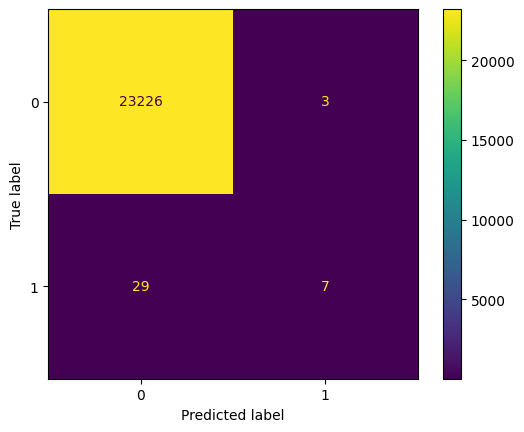

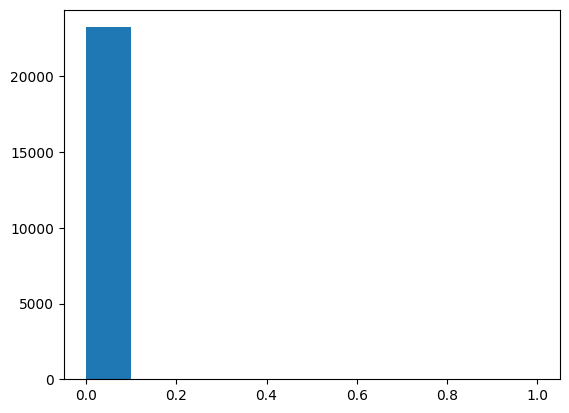

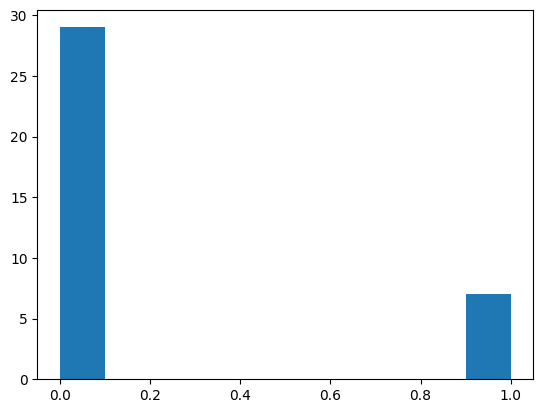

In [17]:
test_final_model(study100.best_params, df_set_100)


Training metrics
Accuracy: 0.9988
Precision: 1.0000
Recall: 0.2000
F1 Score: 0.3333
ROC AUC: 0.9722


Final model on test data:
Roc_Auc on test - 0.6110680614748806
F1 on test - 0.34782608695652173
precision on test - 0.8
recall on test - 0.2222222222222222


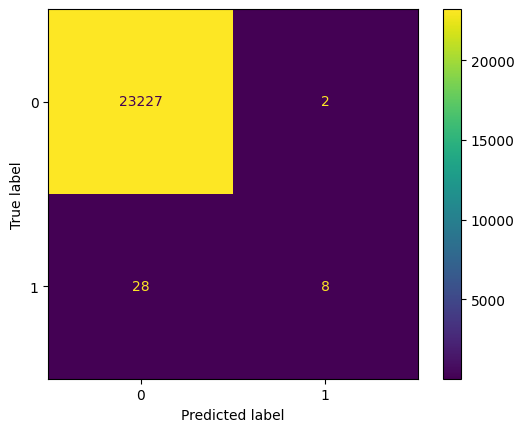

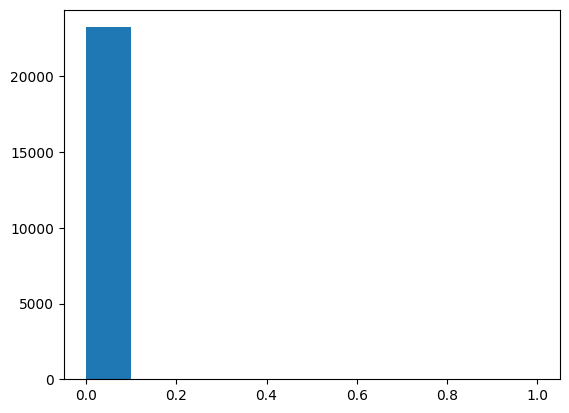

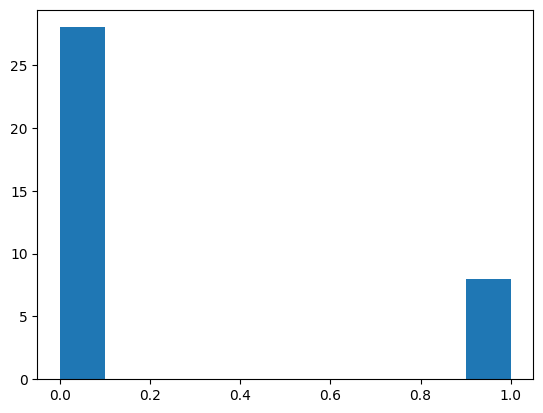

In [18]:
test_final_model(study256.best_params, df_set_256)


Training metrics
Accuracy: 0.9987
Precision: 0.7500
Recall: 0.2000
F1 Score: 0.3158
ROC AUC: 0.9930


Final model on test data:
Roc_Auc on test - 0.6388888888888888
F1 on test - 0.43478260869565216
precision on test - 1.0
recall on test - 0.2777777777777778


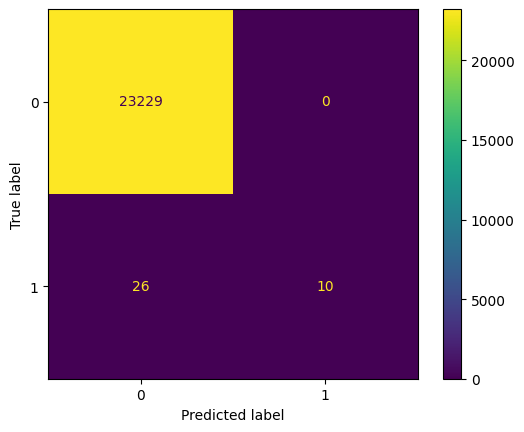

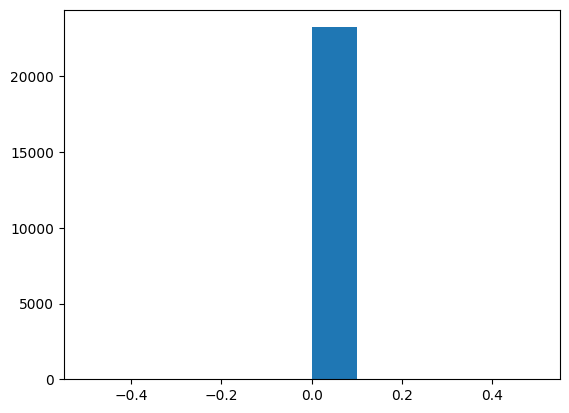

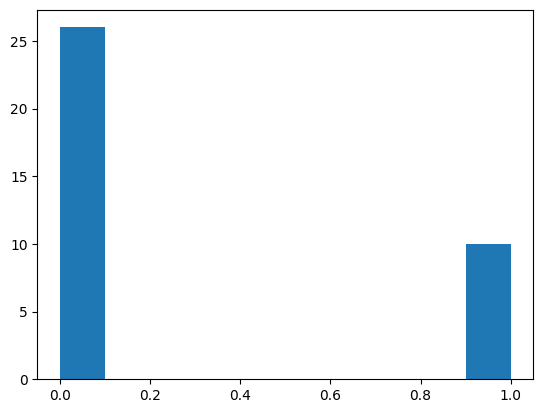

In [19]:
test_final_model(study512.best_params, df_set_512)

In [20]:
#from optuna.visualization import plot_optimization_history, plot_param_importances

import plotly
import nbformat
from plotly.io import show

#print(plotly.__version__)
#print(nbformat.__version__)

def plot_opt(optuna_study):
    fig = optuna.visualization.plot_optimization_history(optuna_study)
    fig.show()

In [21]:
plot_opt(study100)

In [22]:
plot_opt(study256)

In [23]:
plot_opt(study512)